In [1]:
! pip install torchinfo

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchinfo import summary
import PIL
from tabulate import tabulate
from tqdm import tqdm
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, 
                             log_loss, matthews_corrcoef, roc_curve, precision_recall_curve)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

In [3]:
label_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
}

# Load Data

In [5]:
# Load our Train Data and specify what transform to use when loading
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=data_transforms['train'])

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,download=True, transform=data_transforms['val'])

# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False, num_workers=2)

# visualize images from train data

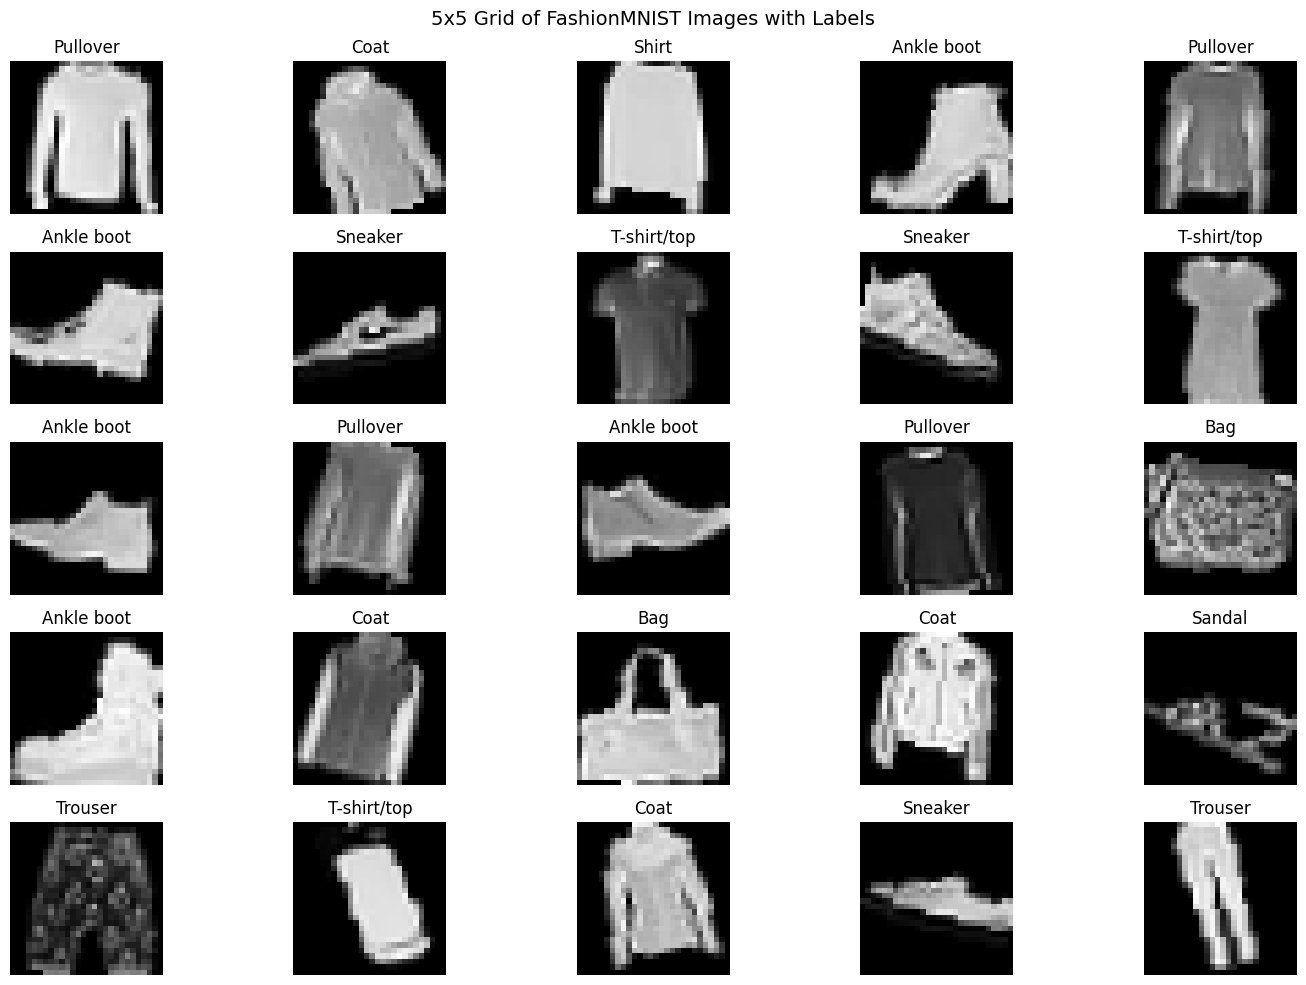

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

def denormalize(img):
    img = img * 0.5 + 0.5
    return img.clamp(0, 1)

fig, axes = plt.subplots(5, 5, figsize=(15, 10))
fig.suptitle("5x5 Grid of FashionMNIST Images with Labels", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = torchvision.utils.make_grid(images[i]).permute(1, 2, 0)
        ax.imshow(denormalize(img), cmap="gray")
        ax.set_title(label_name[labels[i].item()])
        ax.axis("off")

plt.tight_layout()
plt.show()

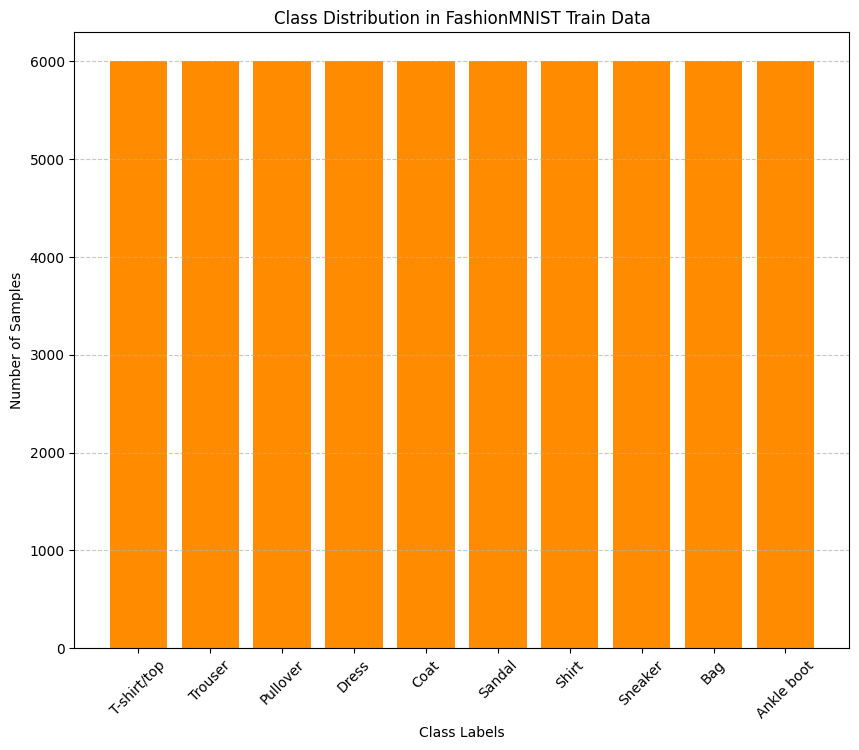

In [7]:
class_counts = Counter(trainset.targets.numpy())

plt.figure(figsize=(10, 8))
plt.bar(label_name, [class_counts[i] for i in range(10)], color='darkorange')

plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in FashionMNIST Train Data")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Building Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Adding BatchNorm, using 32 as the input since 32 was the output of our first Conv layer
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Adding BatchNorm, using 64 as the input since 64 was the output of our first Conv layer
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        # Defining our dropout function with a rate of 0.2
        # We can apply this after any layer, but it's best suited after ReLU
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))

        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()
model.to(device)
summary(model,input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 10]                  --
├─Conv2d: 1-1                            [32, 32, 26, 26]          320
├─BatchNorm2d: 1-2                       [32, 32, 26, 26]          64
├─Dropout: 1-3                           [32, 32, 26, 26]          --
├─Conv2d: 1-4                            [32, 64, 24, 24]          18,496
├─BatchNorm2d: 1-5                       [32, 64, 24, 24]          128
├─Dropout: 1-6                           [32, 64, 24, 24]          --
├─MaxPool2d: 1-7                         [32, 64, 12, 12]          --
├─Linear: 1-8                            [32, 128]                 1,179,776
├─Linear: 1-9                            [32, 10]                  1,290
Total params: 1,200,074
Trainable params: 1,200,074
Non-trainable params: 0
Total mult-adds (M): 385.64
Input size (MB): 0.10
Forward/backward pass size (MB): 29.99
Params size (MB): 4.80
Estimated Total Size 

# Loss & Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

# Train & Validation Loop

In [10]:
def train(model, trainloader, testloader, optimizer, criterion, num_epochs, device):
    model.to(device)

    headers = ["Epoch", "Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"]
    table = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(trainloader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as train_bar:
            for inputs, labels in train_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                train_bar.set_postfix(train_loss=train_loss / (total_train / len(trainloader)),
                                      train_accuracy=100 * correct_train / total_train)

        train_loss /= len(trainloader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with tqdm(testloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch") as test_bar:
            with torch.no_grad():
                for inputs, labels in test_bar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()
                    test_bar.set_postfix(test_loss=test_loss / (total_test / len(testloader)),
                                         test_accuracy=100 * correct_test / total_test)

        test_loss /= len(testloader)
        test_accuracy = 100 * correct_test / total_test

        table.append([epoch+1, f"{train_loss:.4f}", f"{train_accuracy:.2f}%", f"{test_loss:.4f}", f"{test_accuracy:.2f}%"])

    print("\nTraining Summary:")
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

    return table

history = train(model, trainloader, testloader, optimizer, criterion, num_epochs=10, device=device)

Validation Epoch 10/10: 100%|██████████| 313/313 [00:01<00:00, 168.63batch/s, test_accuracy=90.5, test_loss=2.52]


Training Summary:
╒═════════╤══════════════╤══════════════════╤═════════════╤═════════════════╕
│   Epoch │   Train Loss │ Train Accuracy   │   Test Loss │ Test Accuracy   │
╞═════════╪══════════════╪══════════════════╪═════════════╪═════════════════╡
│       1 │       0.5909 │ 78.31%           │      0.3931 │ 85.72%          │
├─────────┼──────────────┼──────────────────┼─────────────┼─────────────────┤
│       2 │       0.4419 │ 83.48%           │      0.3869 │ 85.76%          │
├─────────┼──────────────┼──────────────────┼─────────────┼─────────────────┤
│       3 │       0.3987 │ 85.12%           │      0.3325 │ 88.03%          │
├─────────┼──────────────┼──────────────────┼─────────────┼─────────────────┤
│       4 │       0.3718 │ 86.21%           │      0.325  │ 88.60%          │
├─────────┼──────────────┼──────────────────┼─────────────┼─────────────────┤
│       5 │       0.3474 │ 87.14%           │      0.2991 │ 89.08%          │
├─────────┼──────────────┼──────────────────┼

# Loss & Accuracy Graph

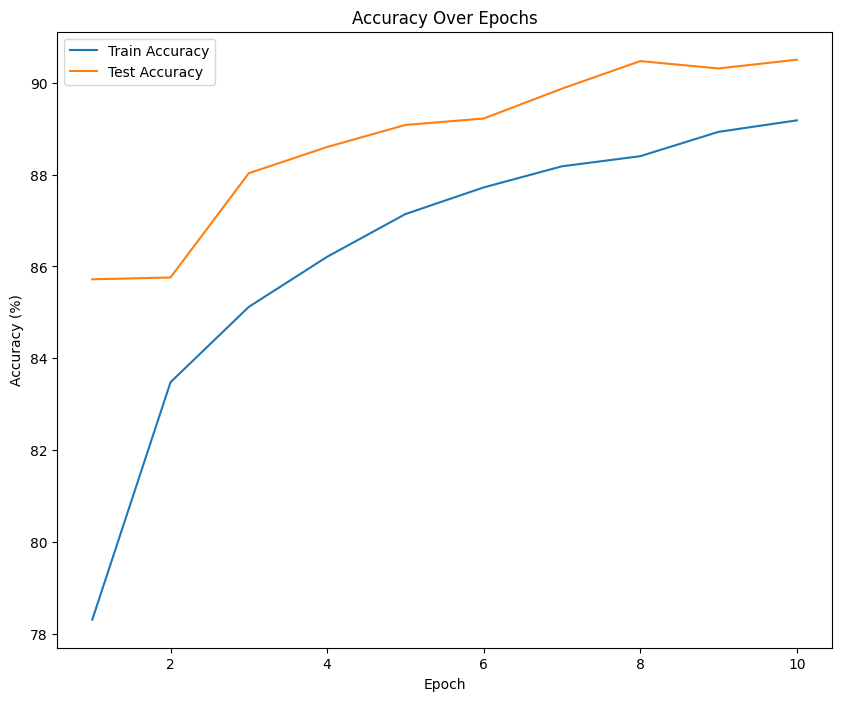

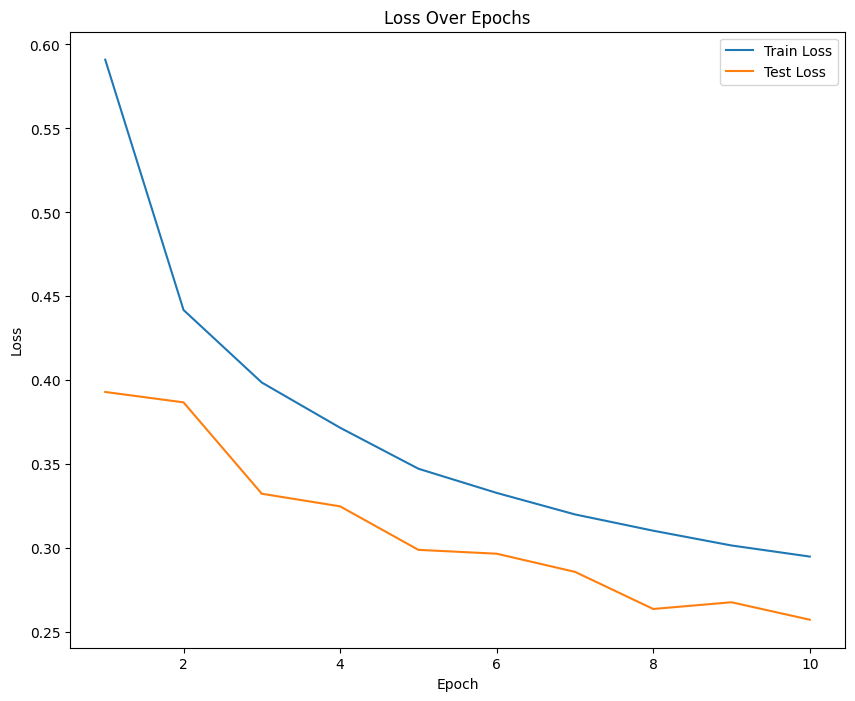

In [11]:
epochs_list = [row[0] for row in history]
train_losses = [float(row[1]) for row in history]
train_accs = [float(row[2].strip('%')) for row in history]
test_losses = [float(row[3]) for row in history]
test_accs = [float(row[4].strip('%')) for row in history]

plt.figure(figsize=(10, 8))
plt.plot(epochs_list, train_accs, label='Train Accuracy')
plt.plot(epochs_list, test_accs, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.plot(epochs_list, test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Accuracy

In [12]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 90.5%


# Model prediction

In [13]:
true_labels=[]
prediction=[]

model.eval()

with tqdm(testloader,desc="Model Prediction",unit="batch") as pred_bar:
    with torch.no_grad():
        for inputs,labels in pred_bar:
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
            _,predicted=torch.max(outputs.data,1)
            true_labels.extend(labels.cpu().numpy())
            prediction.extend(predicted.cpu().numpy())

Model Prediction: 100%|██████████| 313/313 [00:01<00:00, 174.06batch/s]


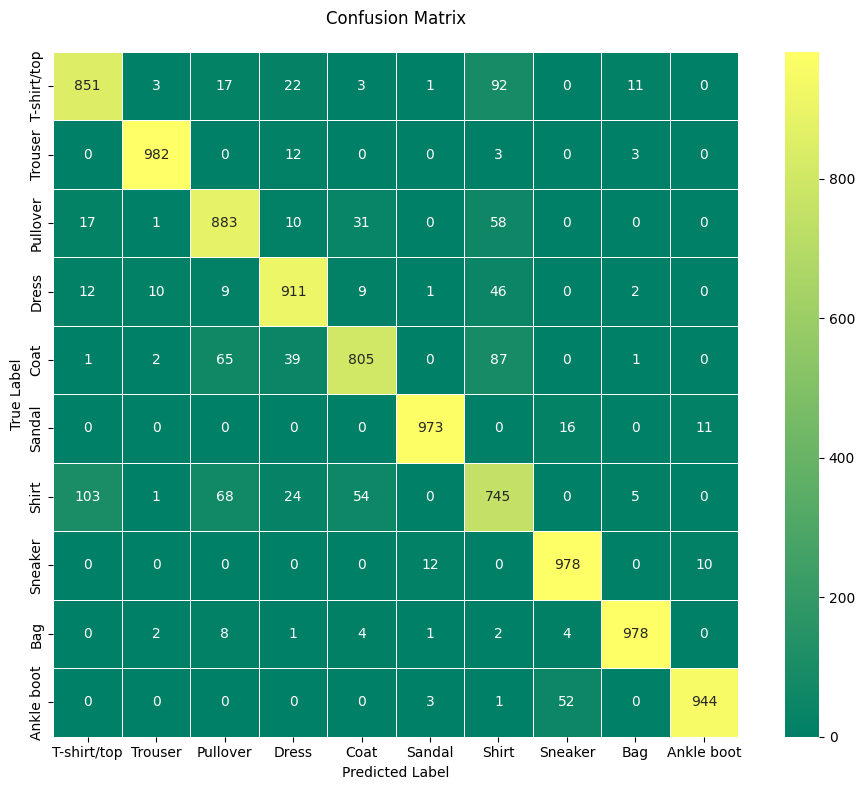

In [14]:
cm = confusion_matrix(true_labels, prediction)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='summer', cbar=True, square=True, linewidths=0.5,xticklabels=label_name,
           yticklabels=label_name)
plt.title('Confusion Matrix', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [15]:
print(classification_report(true_labels,prediction,target_names=label_name))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.86      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.84      0.88      0.86      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.89      0.81      0.84      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.72      0.74      0.73      1000
     Sneaker       0.93      0.98      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

